In [1]:
from pysqlite2 import dbapi2 as sql
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
db = "/home/eric/Documents/franklin/narsc2018/generated_data/narsc18.sqlite"
con = sql.connect(db)
qry = '''
SELECT 
A.CL8AA1990 AS pop90,
A.CL8AA2000 AS pop00,
A.CL8AA2010 AS pop10,
B.*,
C.metro,
C.econdep
FROM nhgis_pop_race_norm_90_10 AS A
JOIN county_gini AS B ON A.GISJOIN = B.GISJOIN
JOIN usda_typology_2004 AS C 
    ON  A.STATEA || A.COUNTYA = C.FIPSTXT
;
'''
df = pd.read_sql(qry, con, index_col='GISJOIN')
con.close()
df.head()

,pop90,pop00,pop10,gini_10,theil_10,gini_00,theil_00,gini_90,theil_90,metro,econdep
GISJOIN,,,,,,,,,,,
G0100010,34223.68,43672.90,54571,0.449228,0.336428,0.435732,0.314436,0.421720,0.292588,1,3
G0100030,98280.00,140415.00,182265,0.460482,0.355500,0.440738,0.322483,0.425888,0.298985,0,5
G0100050,25417.62,29038.85,27457,0.502484,0.432930,0.508892,0.445657,0.466285,0.365601,0,3
G0100070,16610.89,20826.41,22915,0.452703,0.342245,0.447818,0.334085,0.433071,0.310212,1,6
G0100090,39251.65,51028.61,57322,0.443153,0.326411,0.434531,0.312525,0.420266,0.290377,1,6


In [6]:
# merge with census regions
db = "/home/eric/Documents/franklin/narsc2018/generated_data/narsc18.sqlite"
con = sql.connect(db)
con.enable_load_extension(True)
con.execute("SELECT load_extension('mod_spatialite');")

qry = '''
SELECT A.gisjoin, B.name AS region
FROM us_county_2010 AS A, census_regions_10 AS B
WHERE ST_Contains(B.geometry, ST_Centroid(A.geometry))
AND A.ROWID IN (SELECT ROWID FROM SpatialIndex
    WHERE f_table_name = 'us_county_2010' AND search_frame = B.geometry )
;
'''

df2 = pd.read_sql(qry, con, index_col='gisjoin')
con.close()
df = pd.merge(df, df2, left_index=True, right_index=True)
print len(df)

3131


In [7]:
# create categories for pop change 2000 to 2010
# calc pop change in each decade
df['ppctchg_0010'] = ( df['pop10'] - df['pop00'] ) * 1.0 / df['pop00'] * 100
df['ppctchg_9000'] = ( df['pop00'] - df['pop90'] ) * 1.0 / df['pop90'] * 100
# growth categories 2000-2010
df['growth_cat'] = 0
df.loc[df['ppctchg_0010'] >= 5, 'growth_cat'] = 'growing'
df.loc[(df['ppctchg_0010'] < 5) & (df['ppctchg_0010'] >= 0 ), 'growth_cat'] = 'stable'
df.loc[df['ppctchg_0010'] < 0, 'growth_cat'] = 'shrinking'
# growth categories 1990-2000
df['growth_cat_90s'] = 0
df.loc[df['ppctchg_9000'] >= 5, 'growth_cat_90s'] = 'growing'
df.loc[(df['ppctchg_9000'] < 5) & (df['ppctchg_9000'] >= 0 ), 'growth_cat_90s'] = 'stable'
df.loc[df['ppctchg_9000'] < 0, 'growth_cat_90s'] = 'shrinking'
# xtab counties between 1990s and 2000s in terms of pop change category
pd.crosstab(df['growth_cat_90s'], df['growth_cat'], margins=True)

growth_cat,growing,shrinking,stable,All
growth_cat_90s,,,,
growing,1193,292,458,1943
shrinking,47,531,99,677
stable,57,270,184,511
All,1297,1093,741,3131


Text(0.5,1,u'2000-2010')

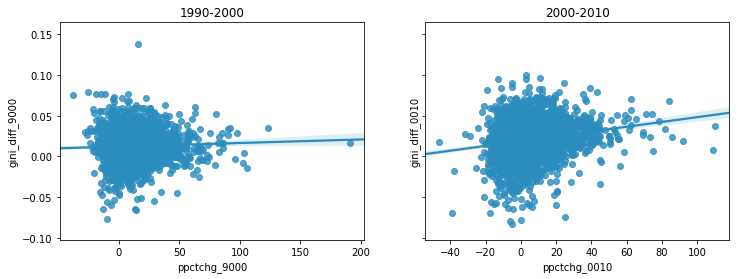

In [9]:
# plot difference in segregation score against percent pop change for both periods
w = 12
h = 4
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(w,h))

df['gini_diff_9000'] = df['gini_00'] - df['gini_90']
df['gini_diff_0010'] = df['gini_10'] - df['gini_00']

# df.plot.scatter('ppctchg_9000', 'seg_diff_4grp_9000', ax=ax1)
# df.plot.scatter('ppctchg_0010', 'seg_diff_4grp_0010', ax=ax2)
sns.regplot('ppctchg_9000', 'gini_diff_9000', df, ax=ax1, color='#2b8cbe')
sns.regplot('ppctchg_0010', 'gini_diff_0010', df, ax=ax2, color='#2b8cbe')
ax1.set_title('1990-2000')
ax2.set_title('2000-2010')

Text(0.5,1,u'2000-2010')

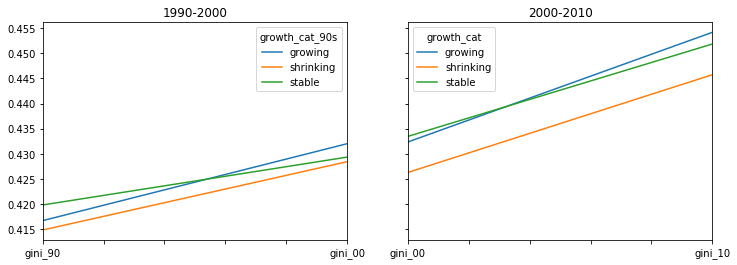

In [10]:
# plot change in median diversity across periods
# calculated using four groups

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(w,h))
cols1 = ['gini_90', 'gini_00']
cols2 = ['gini_00', 'gini_10']
df.groupby('growth_cat_90s')[cols1].median().transpose().plot(ax=ax1)
df.groupby('growth_cat')[cols2].median().transpose().plot(ax=ax2)
ax1.set_title('1990-2000')
ax2.set_title('2000-2010')

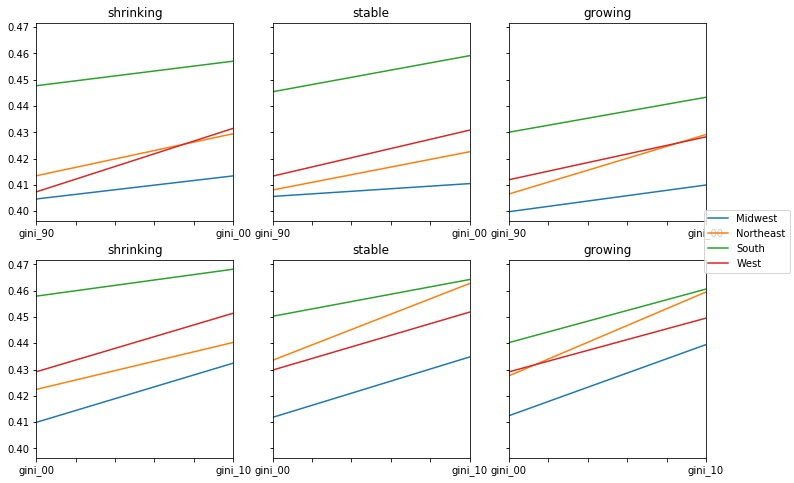

In [16]:
# show change by region
# first row shows change by growth cat and region 1990 - 2000
# second row shows same data for 2000 - 2010

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, sharey=True, figsize=(12,8))

lst = [ (ax1, 'shrinking'), (ax2, 'stable'), (ax3, 'growing') ]

cols1 = ['gini_90', 'gini_00']
cols2 = ['gini_00', 'gini_10']

for a, b in lst:
    df.loc[df['growth_cat_90s']==b].groupby('region')[cols1].median().transpose().plot(ax=a, legend=False)
    a.set_title(b)
    
lst = [ (ax4, 'shrinking'), (ax5, 'stable'), (ax6, 'growing') ]

for a, b in lst:
    df.loc[df['growth_cat']==b].groupby('region')[cols2].median().transpose().plot(ax=a, legend=False)
    a.set_title(b)
    
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')

In [18]:
# add labels for usda 2004 county typology codes
df['econdep_lbl'] = None
df.loc[df['econdep']==1, 'econdep_lbl'] = 'farming'
df.loc[df['econdep']==2, 'econdep_lbl'] = 'mining'
df.loc[df['econdep']==3, 'econdep_lbl'] = 'manufac'
df.loc[df['econdep']==4, 'econdep_lbl'] = 'govt'
df.loc[df['econdep']==5, 'econdep_lbl'] = 'services'
df.loc[df['econdep']==6, 'econdep_lbl'] = 'nonspec'

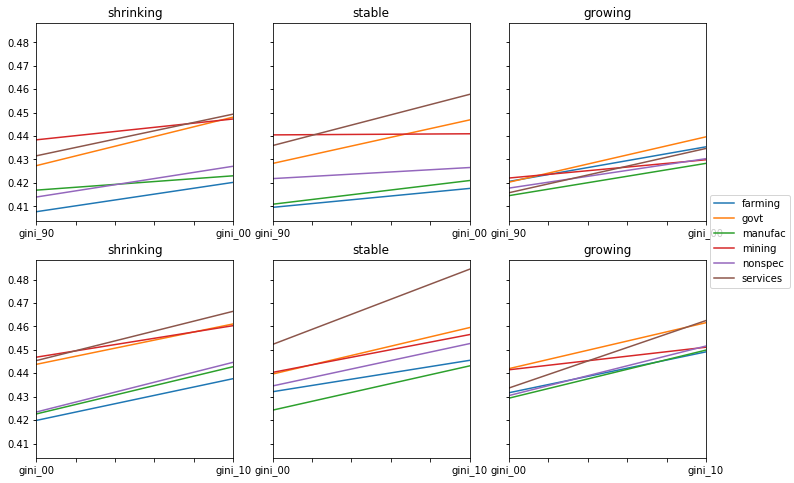

In [19]:
# show change by economic dependence
# first row shows change by growth cat and econdep 1990 - 2000
# second row shows same data for 2000 - 2010

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, sharey=True, figsize=(12,8))

cols1 = ['gini_90', 'gini_00']
cols2 = ['gini_00', 'gini_10']

lst = [ (ax1, 'shrinking'), (ax2, 'stable'), (ax3, 'growing') ]

for a, b in lst:
    df.loc[df['growth_cat_90s']==b].groupby('econdep_lbl')[cols1].median().transpose().plot(ax=a, legend=False)
    a.set_title(b)

lst = [ (ax4, 'shrinking'), (ax5, 'stable'), (ax6, 'growing') ]

for a, b in lst:
    df.loc[df['growth_cat']==b].groupby('econdep_lbl')[cols2].median().transpose().plot(ax=a, legend=False)
    a.set_title(b)
    
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')